# Statystyka i analiza danych - Zadanie domowe

**Dariusz Max Adamski**<br>
grupa i2, czwartek 16:50

## Opis zbioru danych

Przedmiotem analizy będzie zbiór danych z parametrami i oceną jakości portugalskich białych win.
Są to dane obserwacyjne z 4898 próbkami.
W analizie skupię się na jakości wina i zawartości alkoholu.

Dane pochodzą z artykułu P. Corteza et. al.
"Modeling wine preferences by data mining from physicochemical properties".
Zbiór danych jest dostępny na serwerach UCI (University of California, Irvine):
[link](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

Badane zmienne i ich typy zamieściłem w poniższej tabelce:

| angielska nazwa zmiennej | polska nazwa zmiennej      | skala pomiarowa | typ zmiennej
|--------------------------|----------------------------|-----------------|-------------
| fixed acidity            | stała kwasowość            | ilorazowa       | ilościowa ciągła
| volatile acidity         | lotna kwasowość            | ilorazowa       | ilościowa ciągła
| citric acid              | kwas cytrynowy             | ilorazowa       | ilościowa ciągła
| residual sugar           | resztkowe chlorki cukru    | ilorazowa       | ilościowa ciągła
| free sulfur dioxide      | wolny siarkowodlenek       | ilorazowa       | ilościowa dyskretna
| total sulfur dioxide     | całkowity dwutlenek siarki | ilorazowa       | ilościowa dyskretna
| density                  | gęstość                    | ilorazowa       | ilościowa ciągła
| pH                       | pH                         | ilorazowa       | ilościowa ciągła
| sulphates                | siarczany                  | ilorazowa       | ilościowa ciągła
| alcohol                  | alkohol                    | ilorazowa       | ilościowa ciągła
| quality                  | jakość                     | porządkowa      | jakościowa porządkowa od 0 do 10

Wszystkie zmienne poza jakością to obserwacje z objektywnych testów, na przykład pH.<br>
Jakość to mediana z co najmniej trzech ocen ekspertów. Każdy ekspert oceniał jakość na skali od 0 (bardzo niska jakość) do 10 (bardzo dobra jakość).

---

In [12]:
library(ggplot2)   # wykresy z gramatyką grafiki
library(corrplot)  # wykres korelacji
library(purrr)     # funkcyjne narzędzia

In [2]:
URL <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
X <- read.csv(URL, sep=';', stringsAsFactors=FALSE)

## Analiza eksploracyjna

Na początek zróbmy szybki przegląd danych

In [3]:
cat("liczba zmiennych:  ", ncol(X), "\n")
cat("liczba obserwacji: ", nrow(X), "\n")
head(X)

liczba zmiennych:   12 
liczba obserwacji:  4898 


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


Następnie obliczmy wartości statystyk opisowych dla zmiennych.

Do analizy danych użyłem miar rozstępu, dominanty (mody), mediany, średniej i odchylenia standardowego (wyliczonego jako pierwiastek z wariancji z próby: $\sqrt{s^2}$).

Wszystkie zmienne poza jakością są wyrażone na skali ilorazowej, więc użycie rozstęp, mediana, średnia i odchylenie standardowe są przydatne do analizy.

Jakość jest wyrażona na skali porządkowej, więc dodatkowo zwracam uwagę na dominantę.

Warto wspomnieć, że wartości średnie i mediana zmiennych są podobne, co sugeruje małą ilość obserwacji odstających (outliers)

In [4]:
stats <- data.frame(row.names=c('min', 'max', 'rozstęp', 'moda', 'mediana', 'średnia', 'stdev'))
prec <- 3

for (name in colnames(X)) {
    x <- X[,name]
    moda <- names(table(x))[table(x) == max(table(x))]
    mini <- min(x)
    maxi <- max(x)
    stats[,name] <- c(
        mini, maxi, maxi - mini, moda, median(x), round(mean(x), prec), round(sqrt(var(x)), prec))
}

stats

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
min,3.8,0.08,0,0.6,0.009,2,9,0.98711,2.72,0.22,8,3
max,14.2,1.1,1.66,65.8,0.346,289,440,1.03898,3.82,1.08,14.2,9
rozstęp,10.4,1.02,1.66,65.2,0.337,287,431,0.05187,1.1,0.86,6.2,6
moda,6.8,0.28,0.3,1.2,0.044,29,111,0.992,3.14,0.5,9.4,6
mediana,6.8,0.26,0.32,5.2,0.043,34,134,0.99374,3.18,0.47,10.4,6
średnia,6.855,0.278,0.334,6.391,0.046,35.308,138.361,0.994,3.188,0.49,10.514,5.878
stdev,0.844,0.101,0.121,5.072,0.022,17.007,42.498,0.003,0.151,0.114,1.231,0.886


Zobaczmy też jak skorelowane są zmienne

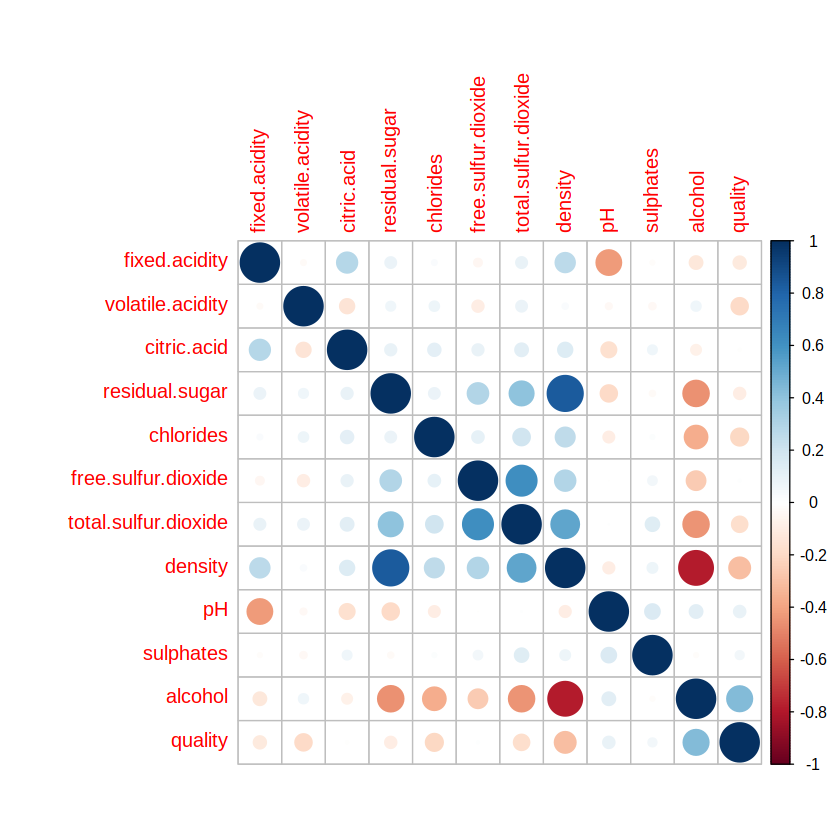

In [5]:
corrplot(cor(X), method = 'circle')

### Szereg rozdzielczy i histogram

Opracujmy szereg rozdzielczy i histogram dla zmiennej opisującej zawartość alkoholu w winie.

Początkową szerokość szeregu obliczam ze wzoru $h = 2.64\ IQR(x)\ n^{-\frac{1}{3}}$.

Następnie ręcznie zwiększałem $\beta$ co 1 w $\alpha^\beta h$, aż histogram stał się czytelny.

In [6]:
x <- X$alcohol
n <- length(x)
h <- 2.64 * IQR(x) * n^(-1/3)

cat("zakres danych:            ", range(x), "\n")
cat("rozstęp danych:           ", max(x) - min(x), "\n")
cat("szerokość przedziału:     ", h, "\n")

zakres danych:             8 14.2 
rozstęp danych:            6.2 
szerokość przedziału:      0.2953597 



   [8,8.53) [8.53,9.06) [9.06,9.59) [9.59,10.1) [10.1,10.7) [10.7,11.2) 
         14         488         939         759         654         569 
[11.2,11.7) [11.7,12.3) [12.3,12.8) [12.8,13.3) [13.3,13.8) [13.8,14.4) 
        542         364         336         172          51          10 

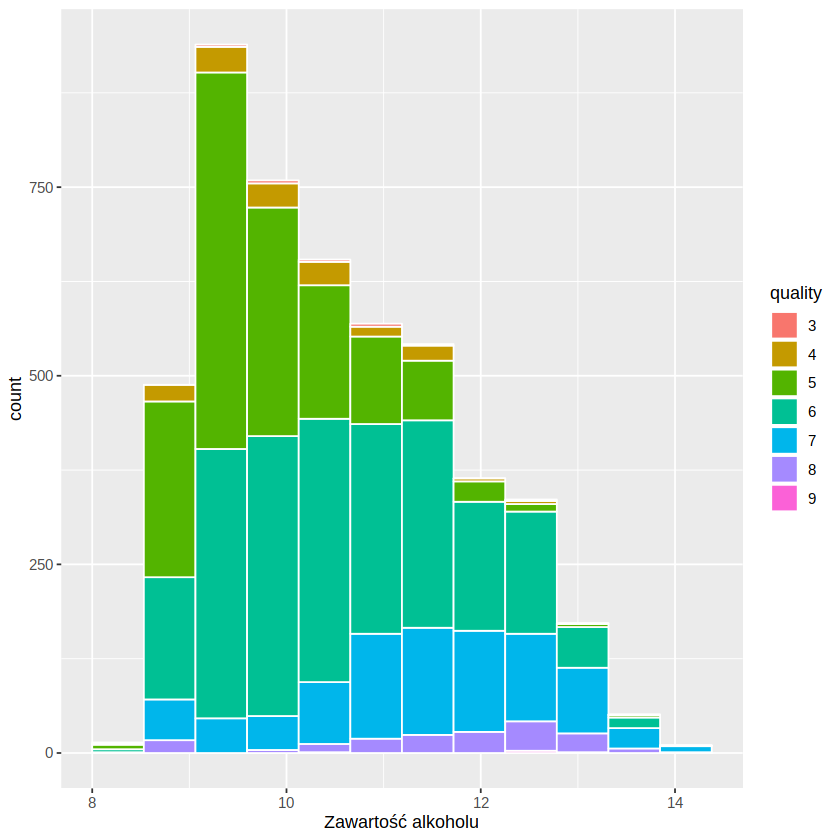

In [7]:
breaks <- seq(8, 14.5, 1.1^6 * 0.3)
table(cut(x, breaks, right=FALSE))

X2 <- X
X2$quality <- as.factor(X2$quality)

ggplot(X2, aes(alcohol, fill=quality)) +
    geom_histogram(breaks=breaks, color='white') +
    labs(x='Zawartość alkoholu')

Narysujmy jeszcze histogram pokazujący ilość win w zależności od oceny

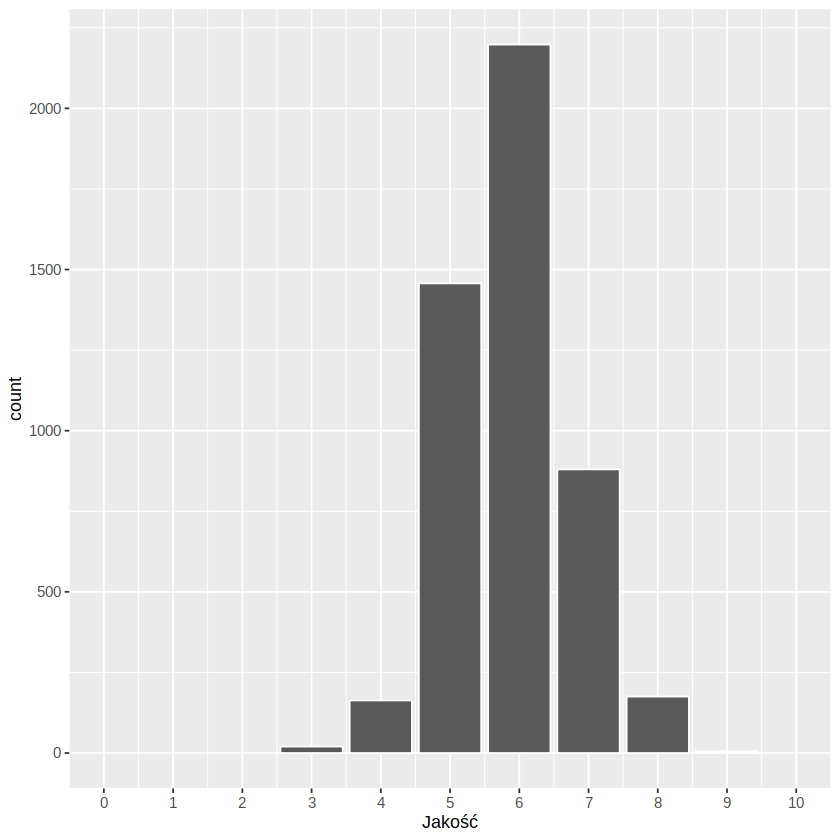

In [8]:
ggplot(X, aes(quality)) +
    geom_bar(color='white') +
    scale_x_continuous(limits=c(0, 10), breaks=0:10) +
    labs(x='Jakość')

### Wnioski

- Alkohol 
    - Większość zbadanych win ma 10.5% zawartość alkoholu z odchyleniem 1.2%
    - W winach występuje rozstęp 6.2% w zawartości alkoholu
    - Zawartość alkoholu jest trochę dodatnio skorelowana z oceną jakości
    - Zawartość alkoholu jest bardzo ujemnie skorelowana z gęstością
- Jakość
    - Większość badanych białych win jest średniej jakości (6)
    - Nie zbadano bardzo niskiej (<3) i bardzo wysokiej (>6) jakości win
    - Ilość win o słabej jakości (<5) zmniejsza się ze wzrostem zawartości alkoholu
    - Wina o zawartości alkoholu większej od 12% są prawie zawsze oceniane na dobre (>=5)

## Testowanie hipotez

In [9]:
z.test <- function(x, mu) (mean(x) - mu) / sqrt(var(x) / length(x))

Czy średnia zawartość alkoholu w białych portugalskich winach jest większa od 10%?

Prawostronny test, przy $\alpha = 0.05$

Duża próba ($n >> 30$), nieznana wariancja, czyli używam testu Z.<br>
Zakładam, że dane pochodzą z rozkładu normalnego.

$H_0$: $\mu \leq 10$<br>
$H_1$: $\mu > 10$

$\Phi^{-1}(1 - 0.05) = 1.64$<br>
$C_{kr} = (1.64, +\infty)$<br>
$Z = 29.25$<br>

**Decyzja**

Są podstawy do odrzucenia hipotezy zerowej $Z \in C_{kr}$.<br>

**Interpretacja**

Średnia zawartość alkoholu w portugalskich winach jest większa od 10%.

In [10]:
Z <- z.test(X$alcohol, 10)
alpha <- 0.05
z_kr <- qnorm(1 - alpha)

print(sprintf("przedział krytyczny: (%.2f, +inf)", z_kr))
print(sprintf("statystyka Z:        %.2f", Z))

[1] "przedział krytyczny: (1.64, +inf)"
[1] "statystyka Z:        29.25"


Dodatkowo sprawdźmy kiedy odrzucimy hipotezę zerową przy różnych $\mu_0$

In [11]:
for (i in seq(10.48, 10.49, 0.001)) {
    Z <- z.test(X$alcohol, i)
    decision <- if (Z > z_kr) "tak" else "nie"
    print(sprintf("mu = %.3f, Z = %+.3f, odrzucenie H0: %s", i, Z, decision))
}

[1] "mu = 10.480, Z = +1.949, odrzucenie H0: tak"
[1] "mu = 10.481, Z = +1.892, odrzucenie H0: tak"
[1] "mu = 10.482, Z = +1.835, odrzucenie H0: tak"
[1] "mu = 10.483, Z = +1.778, odrzucenie H0: tak"
[1] "mu = 10.484, Z = +1.721, odrzucenie H0: tak"
[1] "mu = 10.485, Z = +1.664, odrzucenie H0: tak"
[1] "mu = 10.486, Z = +1.608, odrzucenie H0: nie"
[1] "mu = 10.487, Z = +1.551, odrzucenie H0: nie"
[1] "mu = 10.488, Z = +1.494, odrzucenie H0: nie"
[1] "mu = 10.489, Z = +1.437, odrzucenie H0: nie"
[1] "mu = 10.490, Z = +1.380, odrzucenie H0: nie"


## Bibliografia

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.<br>
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.